# EDA Notebook

This notebook performs exploratory data analysis for predicting whether a product will be **discontinued** at the next range refresh.

**Files expected (place in a `data/` folder by default):**
- `ProductDetails.csv`
- `CatalogueDiscontinuation.csv`

In [1]:
# Consolidated imports
import os
import math
import json
import textwrap
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reproducibility settings (set seeds)
import random
try:
    import numpy as np
except ImportError:
    np = None

SEED = 42
random.seed(SEED)
if np is not None:
    np.random.seed(SEED)


In [3]:
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
plt.rcParams.update({"figure.figsize": (8, 5)})

In [5]:
# ==== Configuration ====
DATA_DIR = os.environ.get("ARGOS_DATA_DIR", "./data")
PRODUCTS_FILE = os.path.join(DATA_DIR, "ProductDetails.csv")
CATALOGUE_FILE = os.path.join(DATA_DIR, "CatalogueDiscontinuation.csv")

OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Reading from:", PRODUCTS_FILE)
print("Reading from:", CATALOGUE_FILE)
print("Writing outputs to:", OUTPUT_DIR)

Reading from: ./data/ProductDetails.csv
Reading from: ./data/CatalogueDiscontinuation.csv
Writing outputs to: ./output


In [7]:
# Load data
prod_dtypes = {
    'ProductKey': 'Int64',
    'Supplier': 'Int64',
    'HierarchyLevel1': 'Int64',
    'HierarchyLevel2': 'Int64',
    'DIorDOM': 'string',
    'Seasonal': 'string',
}

cat_dtypes = {
    'CatEdition': 'Int64',
    'SpringSummer': 'string',
    'ProductKey': 'Int64',
    'WeeksOut': 'Int64',
    'Status': 'string',
    'SalePriceIncVAT': 'float',
    'ForecastPerWeek': 'float',
    'ActualsPerWeek': 'float',
    'DiscontinuedTF': 'string',
}

prod = pd.read_csv(PRODUCTS_FILE, dtype=prod_dtypes)
cat  = pd.read_csv(CATALOGUE_FILE, dtype=cat_dtypes)

# check first 5 rows raw
print("Raw ProductDetails:")
print(prod.head(5))
print("\nRaw Catalogue:")
print(cat.head(5))

# normalize the bool-like fields to Int64 (0/1)
prod["Seasonal"] = prod["Seasonal"].replace({"True": 1, "False": 0}).astype("Int64")
cat["SpringSummer"] = cat["SpringSummer"].replace({"True": 1, "False": 0}).astype("Int64")
cat["DiscontinuedTF"] = cat["DiscontinuedTF"].replace({"True": 1, "False": 0}).astype("Int64")

# check converted output
print("\nNormalized ProductDetails:")
print(prod.head(5))
print("\nNormalized Catalogue:")
print(cat.head(5))

print("ProductDetails shape:", prod.shape)
print("CatalogueDiscontinuation shape:", cat.shape)

Raw ProductDetails:
   ProductKey  Supplier  HierarchyLevel1  HierarchyLevel2 DIorDOM Seasonal
0       30437     13194            80445            28611     DOM    False
1       68587     13194            80445            28611     DOM    False
2       46645     13194            80445            28611     DOM    False
3       49343     13194            80445            28611     DOM    False
4       64223     13194            80445            28611     DOM    False

Raw Catalogue:
   CatEdition SpringSummer  ProductKey  WeeksOut Status  SalePriceIncVAT  ForecastPerWeek  ActualsPerWeek DiscontinuedTF
0          89         True        8108       -11     RI            43.99          250.545         248.642          False
1          89         True        8108       -10     RI            43.99          255.700         244.333          False
2          89         True        8108        -9     RI            43.99          206.111         252.187          False
3          89         True    

/tmp/ipykernel_2442/553651145.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prod["Seasonal"] = prod["Seasonal"].replace({"True": 1, "False": 0}).astype("Int64")
/tmp/ipykernel_2442/553651145.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cat["SpringSummer"] = cat["SpringSummer"].replace({"True": 1, "False": 0}).astype("Int64")



Normalized ProductDetails:
   ProductKey  Supplier  HierarchyLevel1  HierarchyLevel2 DIorDOM  Seasonal
0       30437     13194            80445            28611     DOM         0
1       68587     13194            80445            28611     DOM         0
2       46645     13194            80445            28611     DOM         0
3       49343     13194            80445            28611     DOM         0
4       64223     13194            80445            28611     DOM         0

Normalized Catalogue:
   CatEdition  SpringSummer  ProductKey  WeeksOut Status  SalePriceIncVAT  ForecastPerWeek  ActualsPerWeek  DiscontinuedTF
0          89             1        8108       -11     RI            43.99          250.545         248.642               0
1          89             1        8108       -10     RI            43.99          255.700         244.333               0
2          89             1        8108        -9     RI            43.99          206.111         252.187               0
3

/tmp/ipykernel_2442/553651145.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cat["DiscontinuedTF"] = cat["DiscontinuedTF"].replace({"True": 1, "False": 0}).astype("Int64")


## Normalize booleans & categorical values

In [8]:
def to_bool01(s: pd.Series) -> pd.Series:
    # map any {True, 'true', '1', 1} -> 1; {False, 'false', '0', 0} -> 0
    return (s.astype(str).str.strip().str.lower().isin(["1", "true", "t", "yes", "y"])).astype("int8")

# Normalize boolean-like columns
for col in ["Seasonal"]:
    if col in prod.columns:
        prod[col] = to_bool01(prod[col])

for col in ["SpringSummer", "DiscontinuedTF"]:
    if col in cat.columns:
        cat[col] = to_bool01(cat[col])

# Standardize DIorDOM and Status categories
if "DIorDOM" in prod.columns:
    prod["DIorDOM"] = prod["DIorDOM"].str.strip().str.upper()
    # keep only known values where possible
    valid_didom = {"DI", "DOM"}
    num_invalid = (~prod["DIorDOM"].isin(valid_didom)).sum()
    if num_invalid:
        print(f"Warning: {num_invalid} records have DIorDOM not in {valid_didom}. Leaving as-is.")

if "Status" in cat.columns:
    cat["Status"] = cat["Status"].str.strip().str.upper()
    valid_status = {"RI", "RO"}
    num_invalid = (~cat["Status"].isin(valid_status)).sum()
    if num_invalid:
        print(f"Warning: {num_invalid} records have Status not in {valid_status}. Leaving as-is.")

# Basic info
print("\nDtypes after normalization:")
display(prod.dtypes)
display(cat.dtypes)


Dtypes after normalization:


ProductKey                  Int64
Supplier                    Int64
HierarchyLevel1             Int64
HierarchyLevel2             Int64
DIorDOM            string[python]
Seasonal                     int8
dtype: object

CatEdition                  Int64
SpringSummer                 int8
ProductKey                  Int64
WeeksOut                    Int64
Status             string[python]
SalePriceIncVAT           float64
ForecastPerWeek           float64
ActualsPerWeek            float64
DiscontinuedTF               int8
dtype: object

## Basic integrity checks

In [9]:
def check_duplicates(df: pd.DataFrame, cols: List[str], name: str):
    dup = df.duplicated(subset=cols, keep=False)
    n = int(dup.sum())
    if n:
        print(f"[!] {name}: found {n} duplicate rows by {cols}. Showing a few:")
        display(df.loc[dup].head())
    else:
        print(f"[OK] {name}: no duplicates by {cols}.")

print("ProductDetails uniqueness by ProductKey:")
check_duplicates(prod, ["ProductKey"], "ProductDetails")

print("\nCatalogueDiscontinuation uniqueness by (CatEdition, ProductKey, WeeksOut):")
check_duplicates(cat, ["CatEdition", "ProductKey", "WeeksOut"], "CatalogueDiscontinuation")

ProductDetails uniqueness by ProductKey:
[OK] ProductDetails: no duplicates by ['ProductKey'].

CatalogueDiscontinuation uniqueness by (CatEdition, ProductKey, WeeksOut):
[OK] CatalogueDiscontinuation: no duplicates by ['CatEdition', 'ProductKey', 'WeeksOut'].


## Missingness overview

In [10]:
def missingness(df: pd.DataFrame, name: str):
    miss = (df.isna().mean() * 100).sort_values(ascending=False).to_frame("pct_missing")
    print(f"Missingness in {name}:")
    display(miss)

missingness(prod, "ProductDetails")
missingness(cat, "CatalogueDiscontinuation")

Missingness in ProductDetails:


,pct_missing
ProductKey,0.0
Supplier,0.0
HierarchyLevel1,0.0
HierarchyLevel2,0.0
DIorDOM,0.0
Seasonal,0.0


Missingness in CatalogueDiscontinuation:


,pct_missing
CatEdition,0.0
SpringSummer,0.0
ProductKey,0.0
WeeksOut,0.0
Status,0.0
SalePriceIncVAT,0.0
ForecastPerWeek,0.0
ActualsPerWeek,0.0
DiscontinuedTF,0.0


## Join datasets (snapshot grain: CatEdition × ProductKey × WeeksOut)

In [11]:
df = cat.merge(prod, on="ProductKey", how="left", validate="many_to_one")

print("Joined df shape:", df.shape)
display(df.head())

# Track join coverage
coverage = df["ProductKey"].notna().mean() * 100
print(f"Join coverage (ProductDetails found): {coverage:.2f}%")

num_feats = ["SalePriceIncVAT","ForecastPerWeek","ActualsPerWeek","WeeksOut"]
corr = df[num_feats + ["DiscontinuedTF"]].corr()

# Save a light copy for reference
df.to_parquet(os.path.join(OUTPUT_DIR, "eda_joined.parquet"), index=False)

Joined df shape: (3625659, 14)


,CatEdition,SpringSummer,ProductKey,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF,Supplier,HierarchyLevel1,HierarchyLevel2,DIorDOM,Seasonal
0,89,1,8108,-11,RI,43.99,250.545,248.642,0,78589,67967,32668,DOM,0
1,89,1,8108,-10,RI,43.99,255.700,244.333,0,78589,67967,32668,DOM,0
2,89,1,8108,-9,RI,43.99,206.111,252.187,0,78589,67967,32668,DOM,0
3,89,1,8108,-8,RI,43.99,188.625,254.764,0,78589,67967,32668,DOM,0
4,89,1,8108,-7,RI,43.99,169.142,249.000,0,78589,67967,32668,DOM,0


Join coverage (ProductDetails found): 100.00%


## High-level distributions & target balance

Target balance overall:


,count
DiscontinuedTF,
0,2186167
1,1439492


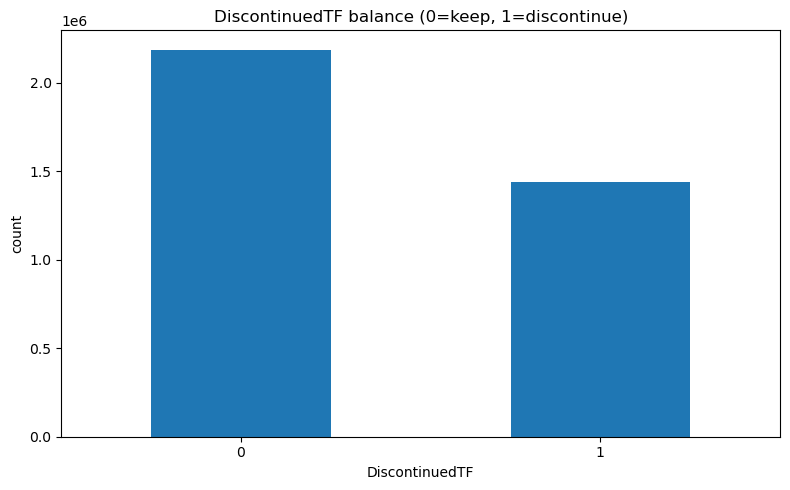

,discontinue_rate
CatEdition,
88,0.358745
89,0.347453
90,0.368698
91,0.299398
92,0.301654
93,0.341554
94,1.000000


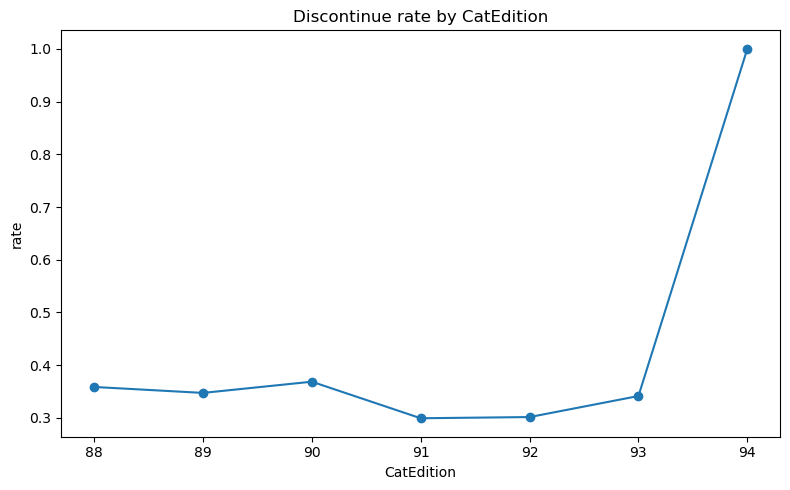

,discontinue_rate
WeeksOut,
-24,0.453632
-23,0.449891
-22,0.453453
-21,0.454736
-20,0.454614
-19,0.454447
-18,0.458012
-17,0.456470
-16,0.455034


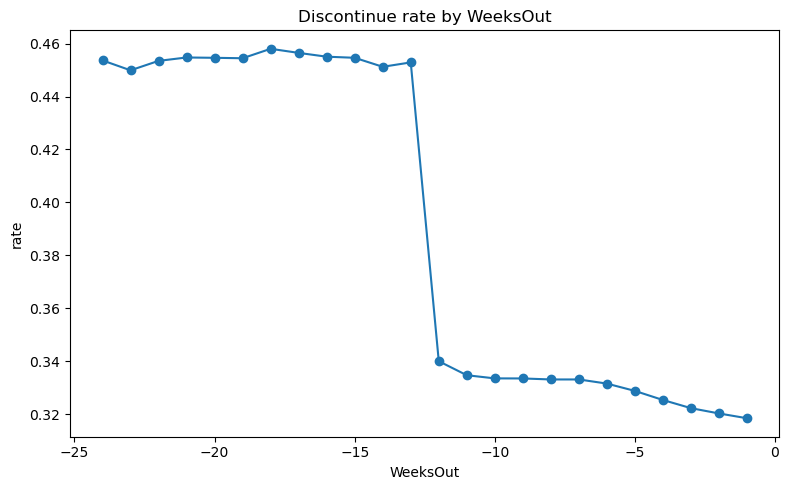

In [12]:
def bar_from_counts(s: pd.Series, title: str, rotation=0):
    counts = s.value_counts(dropna=False).sort_index()
    fig = plt.figure()
    counts.plot(kind="bar", rot=rotation)
    plt.title(title)
    plt.xlabel(s.name)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Target balance
if "DiscontinuedTF" in df.columns:
    print("Target balance overall:")
    display(df["DiscontinuedTF"].value_counts(normalize=False).rename("count").to_frame())
    bar_from_counts(df["DiscontinuedTF"], "DiscontinuedTF balance (0=keep, 1=discontinue)")

# By CatEdition
if "CatEdition" in df.columns and "DiscontinuedTF" in df.columns:
    tmp = df.groupby("CatEdition")["DiscontinuedTF"].mean().rename("discontinue_rate")
    display(tmp.to_frame())
    fig = plt.figure()
    tmp.plot(marker="o")
    plt.title("Discontinue rate by CatEdition")
    plt.xlabel("CatEdition")
    plt.ylabel("rate")
    plt.tight_layout()
    plt.show()

# By WeeksOut
if "WeeksOut" in df.columns and "DiscontinuedTF" in df.columns:
    tmp = df.groupby("WeeksOut")["DiscontinuedTF"].mean().rename("discontinue_rate")
    display(tmp.to_frame())
    fig = plt.figure()
    tmp.plot(marker="o")
    plt.title("Discontinue rate by WeeksOut")
    plt.xlabel("WeeksOut")
    plt.ylabel("rate")
    plt.tight_layout()
    plt.show()

### Discontinue Rate by WeeksOut

The line chart shows the average discontinuation rate as a function of `WeeksOut` (weeks before the catalogue refresh):

- **WeeksOut -24 to -13:** Discontinuation rate is high and stable, around **45–46%**.  
- **WeeksOut -12:** Sharp drop to around **34%**.  
- **WeeksOut -11 to -1:** Discontinuation rate continues to decline gradually, reaching ~32% close to the refresh (0 weeks out).

---

#### Insights:
- **Early horizons (far from refresh, e.g., -24 weeks):** Products appear much more likely to be discontinued. This reflects uncertainty early in the planning cycle, when product decisions are not yet finalized.  
- **Around -12 weeks:** A major shift occurs, with discontinuation rates dropping significantly. This suggests that many range decisions are being finalized around this point.  
- **Closer to refresh (last few weeks):** Discontinuation rates continue to decrease steadily, indicating that products surviving this long are increasingly likely to be retained.

---

#### Business Implication:
- **-24 to -13 weeks:** Predictions are less reliable, as the business is still deciding which products to include.  
- **At ~-12 weeks:** This is a **key decision horizon** — many products are confirmed for inclusion, and predictive models should focus here for early replenishment planning.  
- **At -4 to -1 weeks:** Predictions are highly reliable but offer little lead time for supply adjustments. These are best suited for clearance and markdown planning.

---

#### Decision: Filter Down to Certain Horizons
- Based on the chart, we **filtered the dataset to focus on -12, -8, and -4 weeks**.  
- **Why?**
  - These are the horizons where the business actually makes critical decisions.  
  - Earlier horizons (-24 to -13) are too noisy and do not reflect finalized product decisions.  
  - By filtering, we reduce noise, simplify the dataset, and train models that are directly aligned with real-world decision points.

---

#### Decision: Train Separate Models per Horizon
- The chart shows that **predictive patterns change significantly across horizons**.  
- Instead of one single model across all weeks, we train **separate models per horizon**:
  - **-12 weeks model** → Early-warning signals for long-term planning.  
  - **-8 weeks model** → Balanced reliability with enough time for supplier/stock adjustments.  
  - **-4 weeks model** → Highest accuracy, guiding clearance and last replenishment decisions.  
- This horizon-specific approach ensures model outputs are directly actionable by the replenishment team at the right time.


## Correlation matrix (numeric features)

,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,WeeksOut,CatEdition,SpringSummer,Seasonal,DiscontinuedTF
SalePriceIncVAT,1.000000,-0.077100,-0.095941,0.005904,-0.006708,-0.008421,-0.026644,0.087126
ForecastPerWeek,-0.077100,1.000000,0.639547,0.007302,-0.015415,0.057027,0.068358,-0.105945
ActualsPerWeek,-0.095941,0.639547,1.000000,0.040991,-0.044594,0.037954,0.040435,-0.140518
WeeksOut,0.005904,0.007302,0.040991,1.000000,-0.125917,0.073276,-0.003439,-0.112400
CatEdition,-0.006708,-0.015415,-0.044594,-0.125917,1.000000,0.103997,-0.008796,0.178574
SpringSummer,-0.008421,0.057027,0.037954,0.073276,0.103997,1.000000,-0.004997,-0.129090
Seasonal,-0.026644,0.068358,0.040435,-0.003439,-0.008796,-0.004997,1.000000,-0.025150
DiscontinuedTF,0.087126,-0.105945,-0.140518,-0.112400,0.178574,-0.129090,-0.025150,1.000000


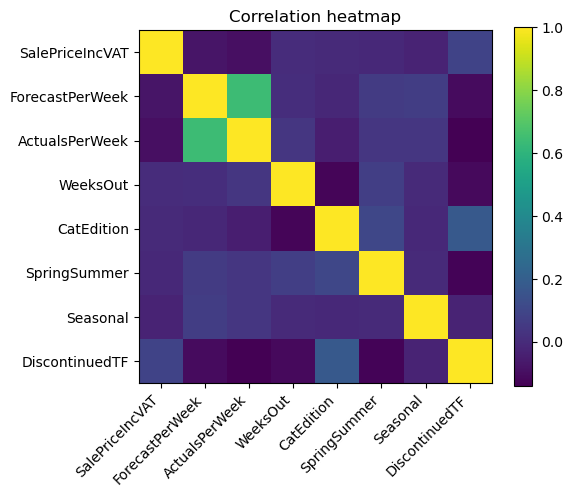

In [13]:
num_for_corr = [c for c in ["SalePriceIncVAT","ForecastPerWeek","ActualsPerWeek","Fcast_to_Actual","WeeksOut","CatEdition","SpringSummer","Seasonal","DiscontinuedTF"] if c in df.columns]
corr = df[num_for_corr].corr(numeric_only=True)
display(corr)

fig = plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(num_for_corr)), num_for_corr, rotation=45, ha="right")
plt.yticks(range(len(num_for_corr)), num_for_corr)
plt.title("Correlation heatmap")
plt.colorbar()
plt.tight_layout()
plt.show()

### Correlation Heatmap (Features vs Target)

The heatmap shows correlations among key features and the target variable (`DiscontinuedTF`):

#### Key Observations:
- **ForecastPerWeek ↔ ActualsPerWeek:**  
  Strong positive correlation (~0.6–0.7).  
  This is expected: products forecasted to sell more generally also show higher actual sales.

- **SalePriceIncVAT ↔ Other variables:**  
  Weak or near-zero correlation with most features.  
  Indicates price has limited direct linear relationship with demand or discontinuation, though non-linear effects may still exist.

- **WeeksOut and CatEdition:**  
  Show very low correlations with most variables.  
  This suggests they provide orthogonal (independent) signals and can still add predictive value.

- **DiscontinuedTF (target):**  
  Shows only weak correlations with individual features (all <0.2).  
  This is typical in business datasets where outcomes depend on a combination of factors rather than a single driver.  
  Implies that a predictive model must **combine multiple signals** to capture discontinuation risk.

#### Implications for Modeling:
- **Forecast and Actual demand** are the strongest demand-related signals and should be retained.  
- **Weak correlations with DiscontinuedTF** highlight the need for advanced models (e.g., tree-based methods or logistic regression with interactions) to capture non-linear relationships.  
- **No features exceed the high-correlation threshold (0.9)** → no need to drop features for multicollinearity concerns at this stage.


## Save a slimmed, cleaned dataset for modeling experiments

In [14]:
cols_to_keep = [c for c in [
    "CatEdition","SpringSummer","ProductKey","WeeksOut","Status",
    "SalePriceIncVAT","ForecastPerWeek","ActualsPerWeek","Fcast_to_Actual",
    "DiscontinuedTF","Supplier","HierarchyLevel1","HierarchyLevel2","DIorDOM","Seasonal"
] if c in df.columns]

model_df = df[cols_to_keep].copy()
model_df.to_parquet(os.path.join(OUTPUT_DIR, "eda_model_ready.parquet"), index=False)
print("Saved:", os.path.join(OUTPUT_DIR, "eda_model_ready.parquet"))
print("Rows:", len(model_df))
display(model_df.sample(min(5, len(model_df))))

Saved: ./output/eda_model_ready.parquet
Rows: 3625659


,CatEdition,SpringSummer,ProductKey,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF,Supplier,HierarchyLevel1,HierarchyLevel2,DIorDOM,Seasonal
2830696,89,1,14297,-9,RI,139.99,73.666,47.625,0,59582,53221,63789,DI,0
2756428,92,0,53353,-8,RI,3.99,121.500,134.176,0,33080,67967,27781,DOM,0
2032565,88,0,40926,-21,RI,14.99,423.952,424.000,0,33716,10159,57189,DOM,0
593321,93,1,12852,-14,RI,50.00,18.357,16.909,0,73968,24739,9740,DI,0
2994211,88,0,64687,-5,RO,7.99,7.800,33.200,1,29876,69740,53044,DOM,0


In [23]:
filtered_df = df[df["WeeksOut"].isin([-12, -8, -4])].copy()

print("Filtered shape:", filtered_df.shape)
print("WeeksOut values kept:", filtered_df["WeeksOut"].unique())

filtered_path = os.path.join(OUTPUT_DIR, "filtered_dataset.parquet")
filtered_df.to_parquet(filtered_path, index=False)

print(f"Filtered dataset saved to: {filtered_path}")

Filtered shape: (415776, 14)
WeeksOut values kept: <IntegerArray>
[-8, -4, -12]
Length: 3, dtype: Int64
Filtered dataset saved to: ./output/filtered_dataset.parquet


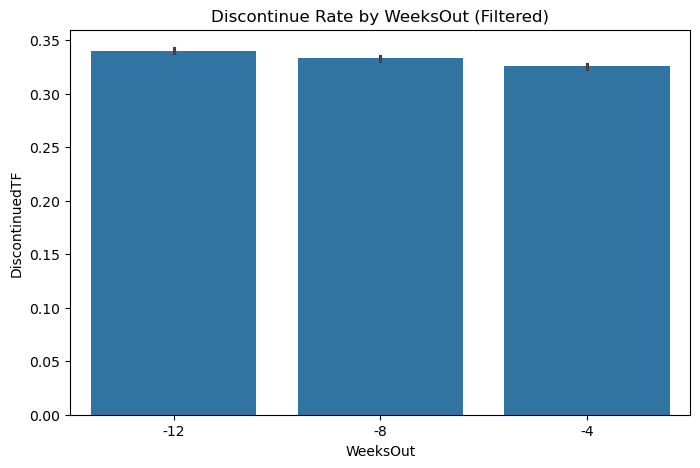

In [16]:
sns.barplot(
    data=filtered_df,
    x="WeeksOut",
    y="DiscontinuedTF",
    estimator="mean"
)
plt.title("Discontinue Rate by WeeksOut (Filtered)")
plt.show()

### Discontinue Rate by WeeksOut (Filtered)

The bar chart shows the average discontinuation rate across the three selected horizons (`WeeksOut = -12, -8, -4`):

| WeeksOut | Discontinue Rate |
|----------|------------------|
| -12      | ~34% |
| -8       | ~33% |
| -4       | ~32% |

#### Key Observations:
- Discontinuation rates are **fairly stable** across these horizons, with only a slight downward trend as the refresh approaches.  
- At **-12 weeks**, the rate is highest (~34%), reflecting greater uncertainty early in the decision process.  
- By **-4 weeks**, the rate falls slightly (~32%), suggesting that products still present this close to the refresh are more likely to be retained.

#### Insights:
- Filtering down to these horizons captures the periods where business decisions are most relevant.  
- The relative stability of discontinuation rates confirms that these filtered horizons provide a consistent basis for modeling.  

#### Business Implication:
- **-12 weeks model:** Provides an early-warning system, useful for long-term planning despite slightly higher uncertainty.  
- **-8 weeks model:** Balances predictive confidence with time for stock or supplier adjustments.  
- **-4 weeks model:** Provides the most reliable predictions, guiding last replenishment and clearance decisions.  
- By training models separately for each horizon, the replenishment team gains tailored insights for decision-making at different lead times.


In [25]:
display(filtered_df.sample(min(5, len(model_df))))

,CatEdition,SpringSummer,ProductKey,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF,Supplier,HierarchyLevel1,HierarchyLevel2,DIorDOM,Seasonal
422145,92,0,42656,-4,RO,79.99,3.750,1.285,1,67203,5434,56920,DI,0
3479002,91,1,7166,-8,RI,130.00,12.625,7.352,0,46940,64400,6840,DOM,0
1047639,93,1,27911,-8,RO,1249.00,10.500,20.235,0,28111,43982,3163,DOM,0
937249,92,0,55842,-12,RO,49.99,5.250,2.307,1,51430,76885,32668,DOM,0
198114,92,0,36535,-4,RI,13.99,41.750,30.380,0,76523,1566,71089,DOM,0


Target balance overall:


,count
DiscontinuedTF,
0,277376
1,138400


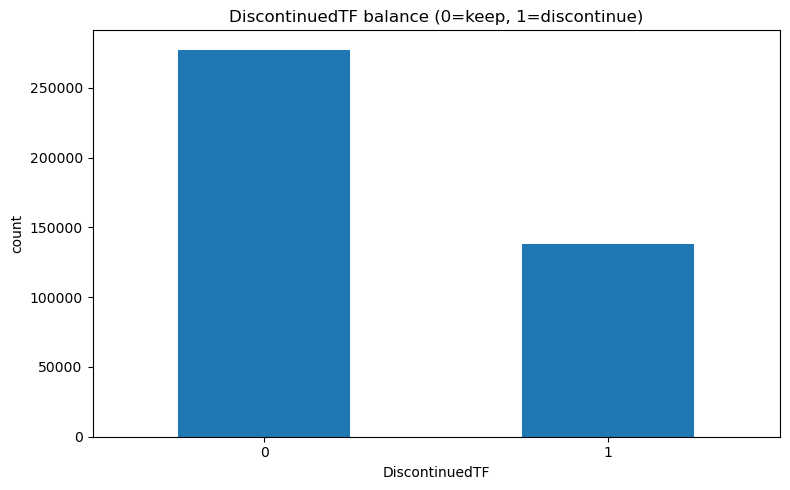

,discontinue_rate
CatEdition,
88,0.353426
89,0.341245
90,0.365844
91,0.295836
92,0.297469
93,0.342182


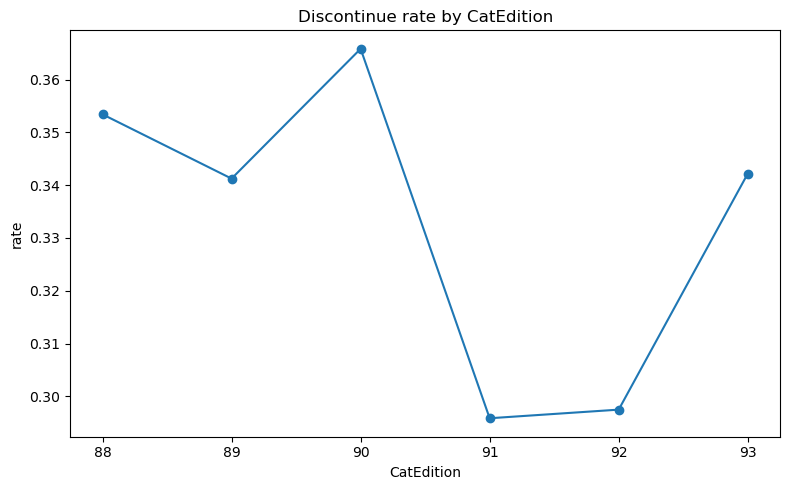

,discontinue_rate
WeeksOut,
-12,0.340049
-8,0.333153
-4,0.325400


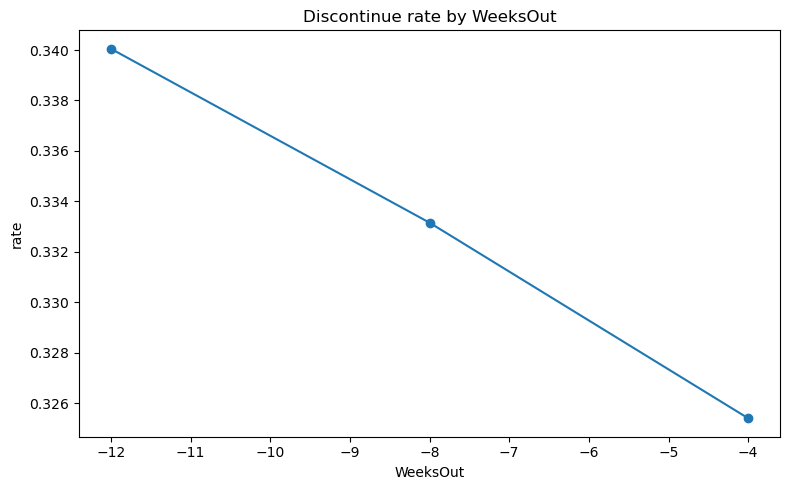

In [26]:
def bar_from_counts(s: pd.Series, title: str, rotation=0):
    counts = s.value_counts(dropna=False).sort_index()
    fig = plt.figure()
    counts.plot(kind="bar", rot=rotation)
    plt.title(title)
    plt.xlabel(s.name)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Target balance
if "DiscontinuedTF" in filtered_df.columns:
    print("Target balance overall:")
    display(filtered_df["DiscontinuedTF"].value_counts(normalize=False).rename("count").to_frame())
    bar_from_counts(filtered_df["DiscontinuedTF"], "DiscontinuedTF balance (0=keep, 1=discontinue)")

# By CatEdition
if "CatEdition" in filtered_df.columns and "DiscontinuedTF" in filtered_df.columns:
    tmp = filtered_df.groupby("CatEdition")["DiscontinuedTF"].mean().rename("discontinue_rate")
    display(tmp.to_frame())
    fig = plt.figure()
    tmp.plot(marker="o")
    plt.title("Discontinue rate by CatEdition")
    plt.xlabel("CatEdition")
    plt.ylabel("rate")
    plt.tight_layout()
    plt.show()

# By WeeksOut
if "WeeksOut" in filtered_df.columns and "DiscontinuedTF" in filtered_df.columns:
    tmp = filtered_df.groupby("WeeksOut")["DiscontinuedTF"].mean().rename("discontinue_rate")
    display(tmp.to_frame())
    fig = plt.figure()
    tmp.plot(marker="o")
    plt.title("Discontinue rate by WeeksOut")
    plt.xlabel("WeeksOut")
    plt.ylabel("rate")
    plt.tight_layout()
    plt.show()

#### Observations
- Variation across editions:
  - **CatEdition 90** highest (~37%).  
  - **CatEditions 91–92** lowest (~29%).  
  - **CatEdition 93** rebounds (~34%).  
- Filtering removed anomalies (e.g., CatEdition 94 at 100%), leaving a smoother, more realistic signal.

#### Modeling Implications
- Target baseline shifts across editions.  
- Use **temporal splits** (e.g., train on 88–92, validate on 93).  
- Filtering yields a more stable signal, improving model reliability.



#### Observations
- Discontinuation rate decreases as refresh approaches:  
  - **-12 weeks:** ~34%  
  - **-8 weeks:** ~33%  
  - **-4 weeks:** ~32.5%  
- Early weeks show more uncertainty; by -4 weeks, decisions are mostly finalized.  
- Filtering to -12, -8, -4 weeks creates a smoother, more realistic signal than the full noisy dataset.

#### Business Implications
- **-12 weeks:** Higher uncertainty, useful for early planning.  
- **-4 weeks:** More reliable predictions, but shorter lead time.  
- Decision uncertainty declines as refresh nears.

#### Modeling Implications
- Keep **WeeksOut** as a feature to capture horizon effects.  
- Train **separate models per horizon** to reflect changing dynamics.  
- Example: -12 weeks for early signals vs -4 weeks for high-confidence actions.


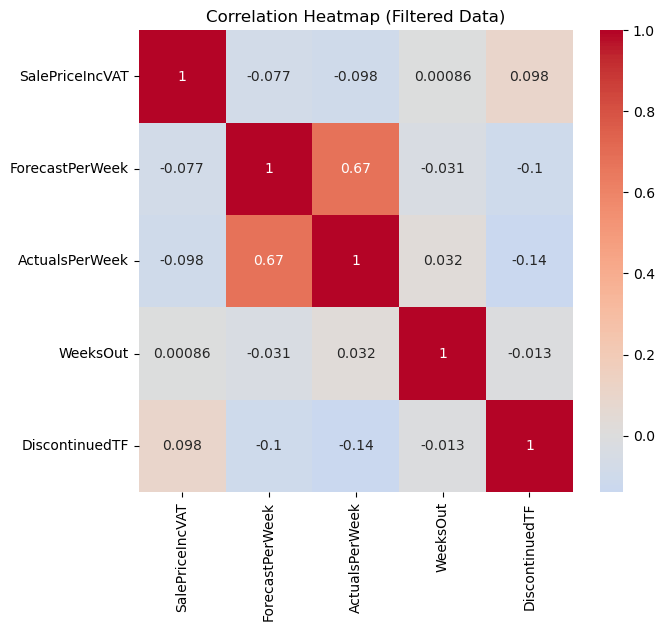

In [27]:
num_feats = ["SalePriceIncVAT","ForecastPerWeek","ActualsPerWeek","WeeksOut"]
corr = filtered_df[num_feats + ["DiscontinuedTF"]].corr()

plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Filtered Data)")
plt.show()